In [1]:
import torch
import torch.nn as nn
import timm
from tqdm import tqdm
import methods
import os
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import json
from io import BytesIO
import requests
from copy import deepcopy
from astropy.nddata import Cutout2D
from torch.nn.utils.rnn import pad_sequence
from itertools import chain
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # latent space size
        hidden_dims = [16, 32, 64] # num of filters in layers
        modules = []
        in_channels = 1 # initial value of channels
        for h_dim in hidden_dims: # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(                    
                        in_channels=in_channels, # num of input channels 
                        out_channels=h_dim, # num of output channels 
                        kernel_size=3, 
                        stride=2, # convolution kernel step
                        padding=1, # save shape
                        bias=False,
                    ),
                    nn.BatchNorm2d(h_dim),  
                    nn.LeakyReLU(), 
                )
            )
            in_channels = h_dim # changing number of input channels for next iteration

 
        modules.append(nn.Flatten()) # to vector, size 512 * 2*2 = 2048
        modules.append(nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)) 

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [64, 32, 16] # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=hidden_dims[0]*4*4) 

        modules = []
        for i in range(len(hidden_dims) - 1): # define ConvTransopse layers
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                        bias=False,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=hidden_dims[-1],
                    out_channels=hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.ReLU(),
                #nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x) # from latents space to Linear 
        x = x.view(-1, 64, 4, 4) # reshape
        x = self.decoder(x) # reconstruction
        return x

In [3]:
class EncoderLin(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # latent space size
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 500),
                                    #nn.BatchNorm1d(600),
                                    nn.ReLU(),
                                     
                                    nn.Linear(500, 300),
                                    nn.BatchNorm1d(300),
                                    nn.ReLU(),
                                    
                                    nn.Linear(300, latent_dim),
                                    #nn.BatchNorm1d(latent_dim),
                                    nn.ReLU(),
                                    )

    def forward(self, x):
        x = self.encoder(x)
        return x


class DecoderLin(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
    
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 300),
                                    #nn.BatchNorm1d(200),
                                    nn.ReLU(),
                                    
                                    nn.Linear(300, 500),
                                    nn.BatchNorm1d(500),
                                    nn.ReLU(),
                                     
                                    nn.Linear(500, 784),
                                    #nn.BatchNorm1d(600),
                                    nn.ReLU(),
                                    
                                    )

    def forward(self, x):
        x = self.decoder(x) # reconstruction
        x = x.view(-1, 1, 28, 28)
        return x
    

    
    
class VAEEncoderLin(EncoderLin):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0: # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_dim)


In [4]:

'''
Function to train model, parameters: 
  enc - encoder
  dec - decoder
  loader - loader of data
  optimizer - optimizer
  single_pass_handler - return reconstructed image, use for loss 
  loss_handler - loss function 
  epoch - num of epochs
  log_interval - output interval
'''


def train(
    enc,
    dec,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):

    for batch_idx, data in enumerate(loader): 
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)

        latent, output = single_pass_handler(encoder, decoder, data) # reconstructed image drom decoder 

        loss = loss_handler(data, output, latent) # compute loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                ).ljust(40), 
                "Loss: {:.6f}".format(loss.item())
            )


In [5]:
torch.manual_seed(42)

class VAEEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0: # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_dim)


def vae_split(latent):
    size = latent.shape[1] // 2 # divide the latent representation into mu and log_var
    mu = latent[:, :size] 
    log_var = latent[:, size:]  
    return mu, log_var


def vae_reparametrize(mu, log_var): 
    sigma = torch.exp(0.5 * log_var) 
    z = torch.randn(mu.shape[0], mu.shape[1]).to(device) 
    return z * sigma + mu 


def vae_pass_handler(encoder, decoder, data, *args, **kwargs): 
    latent = encoder(data) 
    mu, log_var = vae_split(latent) 
    sample = vae_reparametrize(mu, log_var) 
    recon = decoder(sample)
    return latent, recon


def kld_loss(mu, log_var): 
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - var, dim=1), dim=0)
    return kl_loss


class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))



def vae_loss_handler(data, recons, latent, kld_weight=8e-5, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    return kld_weight * kl_loss + LogCoshLoss()(recons, data) #F.mse_loss(recons, data) #F.mse_loss(recons, data) 

In [6]:
'''
Function return transforms results to numpy for visualization 

encoder - encoder
decoder - decoder
loader - loader of data
single_pass_handler - return latent and reconstruction transform
return_real - return original images, True/False, default = True
return_recon - return transformed image from decoder, True/False, default = True
return_latent - return latent representation from encoder, True/False, default = True
return_labels - return labels, True/False, default = True
'''
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data)
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    return result

In [16]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
        if title:
            plt.title(title)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        plt.colorbar()
        if title:
            plt.title(title)
    plt.show()





def plot_imgs(*args, img_size=28, name=None, single_size=2): #, invert_colors=True
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.ones(((img_size + 1) * len(args) + 1, (img_size + 1) * n + 1))*np.max(args)

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * img_size + (j + 1): (j + 1) * img_size + (j + 1),
                i * img_size + (i + 1) : (i + 1) * img_size + (i + 1),
            ] = args[j][i].squeeze()

    #if invert_colors:
    #    figure = 1 - figure

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray")

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name, dpi=400, format='pdf', bbox_inches="tight")
    plt.show()

In [8]:
oids, targets = methods.get_only_r_oids('akb.ztf.snad.space.json')

In [9]:
torch.manual_seed(42)
frames_dataset = methods.AllFramesDataset(oids)
x_train, _ = random_split(frames_dataset, [0.05, 0.95])
train_loader = DataLoader(x_train, batch_size=64, shuffle=True)

In [10]:
len(x_train)

50759

In [11]:
torch.manual_seed(42)

latent_dim = 36

learning_rate = 5e-5
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in tqdm(range(1, 11)):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=50,
    )

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/50759 (0%)]            Loss: 0.026282
Train Epoch: 1 [3200/50759 (6%)]         Loss: 0.026556
Train Epoch: 1 [6400/50759 (13%)]        Loss: 0.026831
Train Epoch: 1 [9600/50759 (19%)]        Loss: 0.018331
Train Epoch: 1 [12800/50759 (25%)]       Loss: 0.019339
Train Epoch: 1 [16000/50759 (31%)]       Loss: 0.012058
Train Epoch: 1 [19200/50759 (38%)]       Loss: 0.014338
Train Epoch: 1 [22400/50759 (44%)]       Loss: 0.013362
Train Epoch: 1 [25600/50759 (50%)]       Loss: 0.009355
Train Epoch: 1 [28800/50759 (57%)]       Loss: 0.010975
Train Epoch: 1 [32000/50759 (63%)]       Loss: 0.006485
Train Epoch: 1 [35200/50759 (69%)]       Loss: 0.006764
Train Epoch: 1 [38400/50759 (76%)]       Loss: 0.008132
Train Epoch: 1 [41600/50759 (82%)]       Loss: 0.009372
Train Epoch: 1 [44800/50759 (88%)]       Loss: 0.006767
Train Epoch: 1 [48000/50759 (94%)]       Loss: 0.005263


 10%|████▎                                      | 1/10 [02:17<20:35, 137.26s/it]

Train Epoch: 2 [0/50759 (0%)]            Loss: 0.006057
Train Epoch: 2 [3200/50759 (6%)]         Loss: 0.005818
Train Epoch: 2 [6400/50759 (13%)]        Loss: 0.005579
Train Epoch: 2 [9600/50759 (19%)]        Loss: 0.005571
Train Epoch: 2 [12800/50759 (25%)]       Loss: 0.004960
Train Epoch: 2 [16000/50759 (31%)]       Loss: 0.004857
Train Epoch: 2 [19200/50759 (38%)]       Loss: 0.005906
Train Epoch: 2 [22400/50759 (44%)]       Loss: 0.004938
Train Epoch: 2 [25600/50759 (50%)]       Loss: 0.005569
Train Epoch: 2 [28800/50759 (57%)]       Loss: 0.004592
Train Epoch: 2 [32000/50759 (63%)]       Loss: 0.004859
Train Epoch: 2 [35200/50759 (69%)]       Loss: 0.006287
Train Epoch: 2 [38400/50759 (76%)]       Loss: 0.005732
Train Epoch: 2 [41600/50759 (82%)]       Loss: 0.005260
Train Epoch: 2 [44800/50759 (88%)]       Loss: 0.005919
Train Epoch: 2 [48000/50759 (94%)]       Loss: 0.005733


 20%|████████▌                                  | 2/10 [04:16<16:54, 126.85s/it]

Train Epoch: 3 [0/50759 (0%)]            Loss: 0.006487
Train Epoch: 3 [3200/50759 (6%)]         Loss: 0.005668
Train Epoch: 3 [6400/50759 (13%)]        Loss: 0.004669
Train Epoch: 3 [9600/50759 (19%)]        Loss: 0.004184
Train Epoch: 3 [12800/50759 (25%)]       Loss: 0.004383
Train Epoch: 3 [16000/50759 (31%)]       Loss: 0.004886
Train Epoch: 3 [19200/50759 (38%)]       Loss: 0.004919
Train Epoch: 3 [22400/50759 (44%)]       Loss: 0.005269
Train Epoch: 3 [25600/50759 (50%)]       Loss: 0.005579
Train Epoch: 3 [28800/50759 (57%)]       Loss: 0.004633
Train Epoch: 3 [32000/50759 (63%)]       Loss: 0.003951
Train Epoch: 3 [35200/50759 (69%)]       Loss: 0.005940
Train Epoch: 3 [38400/50759 (76%)]       Loss: 0.004145
Train Epoch: 3 [41600/50759 (82%)]       Loss: 0.004137
Train Epoch: 3 [44800/50759 (88%)]       Loss: 0.004303
Train Epoch: 3 [48000/50759 (94%)]       Loss: 0.004490


 30%|████████████▉                              | 3/10 [06:04<13:45, 118.00s/it]

Train Epoch: 4 [0/50759 (0%)]            Loss: 0.004135
Train Epoch: 4 [3200/50759 (6%)]         Loss: 0.005678
Train Epoch: 4 [6400/50759 (13%)]        Loss: 0.004670
Train Epoch: 4 [9600/50759 (19%)]        Loss: 0.003624
Train Epoch: 4 [12800/50759 (25%)]       Loss: 0.004991
Train Epoch: 4 [16000/50759 (31%)]       Loss: 0.005126
Train Epoch: 4 [19200/50759 (38%)]       Loss: 0.004847
Train Epoch: 4 [22400/50759 (44%)]       Loss: 0.004584
Train Epoch: 4 [25600/50759 (50%)]       Loss: 0.004364
Train Epoch: 4 [28800/50759 (57%)]       Loss: 0.004918
Train Epoch: 4 [32000/50759 (63%)]       Loss: 0.004599
Train Epoch: 4 [35200/50759 (69%)]       Loss: 0.004649
Train Epoch: 4 [38400/50759 (76%)]       Loss: 0.003735
Train Epoch: 4 [41600/50759 (82%)]       Loss: 0.005151
Train Epoch: 4 [44800/50759 (88%)]       Loss: 0.004126
Train Epoch: 4 [48000/50759 (94%)]       Loss: 0.004544


 40%|█████████████████▏                         | 4/10 [07:53<11:26, 114.37s/it]

Train Epoch: 5 [0/50759 (0%)]            Loss: 0.004039
Train Epoch: 5 [3200/50759 (6%)]         Loss: 0.003883
Train Epoch: 5 [6400/50759 (13%)]        Loss: 0.003989
Train Epoch: 5 [9600/50759 (19%)]        Loss: 0.004309
Train Epoch: 5 [12800/50759 (25%)]       Loss: 0.003905
Train Epoch: 5 [16000/50759 (31%)]       Loss: 0.003836
Train Epoch: 5 [19200/50759 (38%)]       Loss: 0.004758
Train Epoch: 5 [22400/50759 (44%)]       Loss: 0.004637
Train Epoch: 5 [25600/50759 (50%)]       Loss: 0.004757
Train Epoch: 5 [28800/50759 (57%)]       Loss: 0.004298
Train Epoch: 5 [32000/50759 (63%)]       Loss: 0.007419
Train Epoch: 5 [35200/50759 (69%)]       Loss: 0.004584
Train Epoch: 5 [38400/50759 (76%)]       Loss: 0.004482
Train Epoch: 5 [41600/50759 (82%)]       Loss: 0.004799
Train Epoch: 5 [44800/50759 (88%)]       Loss: 0.003610
Train Epoch: 5 [48000/50759 (94%)]       Loss: 0.004894


 50%|█████████████████████▌                     | 5/10 [09:44<09:27, 113.43s/it]

Train Epoch: 6 [0/50759 (0%)]            Loss: 0.004004
Train Epoch: 6 [3200/50759 (6%)]         Loss: 0.003901
Train Epoch: 6 [6400/50759 (13%)]        Loss: 0.004304
Train Epoch: 6 [9600/50759 (19%)]        Loss: 0.003972
Train Epoch: 6 [12800/50759 (25%)]       Loss: 0.004094
Train Epoch: 6 [16000/50759 (31%)]       Loss: 0.004212
Train Epoch: 6 [19200/50759 (38%)]       Loss: 0.004621
Train Epoch: 6 [22400/50759 (44%)]       Loss: 0.003422
Train Epoch: 6 [25600/50759 (50%)]       Loss: 0.004010
Train Epoch: 6 [28800/50759 (57%)]       Loss: 0.005009
Train Epoch: 6 [32000/50759 (63%)]       Loss: 0.003722
Train Epoch: 6 [35200/50759 (69%)]       Loss: 0.003728
Train Epoch: 6 [38400/50759 (76%)]       Loss: 0.003788
Train Epoch: 6 [41600/50759 (82%)]       Loss: 0.004815
Train Epoch: 6 [44800/50759 (88%)]       Loss: 0.004731
Train Epoch: 6 [48000/50759 (94%)]       Loss: 0.003752


 60%|█████████████████████████▊                 | 6/10 [11:38<07:34, 113.56s/it]

Train Epoch: 7 [0/50759 (0%)]            Loss: 0.004197
Train Epoch: 7 [3200/50759 (6%)]         Loss: 0.004292
Train Epoch: 7 [6400/50759 (13%)]        Loss: 0.003380
Train Epoch: 7 [9600/50759 (19%)]        Loss: 0.004294
Train Epoch: 7 [12800/50759 (25%)]       Loss: 0.004593
Train Epoch: 7 [16000/50759 (31%)]       Loss: 0.004374
Train Epoch: 7 [19200/50759 (38%)]       Loss: 0.003578
Train Epoch: 7 [22400/50759 (44%)]       Loss: 0.003710
Train Epoch: 7 [25600/50759 (50%)]       Loss: 0.003852
Train Epoch: 7 [28800/50759 (57%)]       Loss: 0.003990
Train Epoch: 7 [32000/50759 (63%)]       Loss: 0.003585
Train Epoch: 7 [35200/50759 (69%)]       Loss: 0.003631
Train Epoch: 7 [38400/50759 (76%)]       Loss: 0.003483
Train Epoch: 7 [41600/50759 (82%)]       Loss: 0.003566
Train Epoch: 7 [44800/50759 (88%)]       Loss: 0.002899
Train Epoch: 7 [48000/50759 (94%)]       Loss: 0.005121


 70%|██████████████████████████████             | 7/10 [13:34<05:42, 114.14s/it]

Train Epoch: 8 [0/50759 (0%)]            Loss: 0.003766
Train Epoch: 8 [3200/50759 (6%)]         Loss: 0.003655
Train Epoch: 8 [6400/50759 (13%)]        Loss: 0.004366
Train Epoch: 8 [9600/50759 (19%)]        Loss: 0.003538
Train Epoch: 8 [12800/50759 (25%)]       Loss: 0.003980
Train Epoch: 8 [16000/50759 (31%)]       Loss: 0.004865
Train Epoch: 8 [19200/50759 (38%)]       Loss: 0.003387
Train Epoch: 8 [22400/50759 (44%)]       Loss: 0.004317
Train Epoch: 8 [25600/50759 (50%)]       Loss: 0.003457
Train Epoch: 8 [28800/50759 (57%)]       Loss: 0.003272
Train Epoch: 8 [32000/50759 (63%)]       Loss: 0.004061
Train Epoch: 8 [35200/50759 (69%)]       Loss: 0.002998
Train Epoch: 8 [38400/50759 (76%)]       Loss: 0.003506
Train Epoch: 8 [41600/50759 (82%)]       Loss: 0.003796
Train Epoch: 8 [44800/50759 (88%)]       Loss: 0.003082
Train Epoch: 8 [48000/50759 (94%)]       Loss: 0.003210


 80%|██████████████████████████████████▍        | 8/10 [15:24<03:46, 113.04s/it]

Train Epoch: 9 [0/50759 (0%)]            Loss: 0.003422
Train Epoch: 9 [3200/50759 (6%)]         Loss: 0.003756
Train Epoch: 9 [6400/50759 (13%)]        Loss: 0.003728
Train Epoch: 9 [9600/50759 (19%)]        Loss: 0.003704
Train Epoch: 9 [12800/50759 (25%)]       Loss: 0.004388
Train Epoch: 9 [16000/50759 (31%)]       Loss: 0.003906
Train Epoch: 9 [19200/50759 (38%)]       Loss: 0.004034
Train Epoch: 9 [22400/50759 (44%)]       Loss: 0.003797
Train Epoch: 9 [25600/50759 (50%)]       Loss: 0.003818
Train Epoch: 9 [28800/50759 (57%)]       Loss: 0.003931
Train Epoch: 9 [32000/50759 (63%)]       Loss: 0.003342
Train Epoch: 9 [35200/50759 (69%)]       Loss: 0.003784
Train Epoch: 9 [38400/50759 (76%)]       Loss: 0.004260
Train Epoch: 9 [41600/50759 (82%)]       Loss: 0.003699
Train Epoch: 9 [44800/50759 (88%)]       Loss: 0.004929
Train Epoch: 9 [48000/50759 (94%)]       Loss: 0.003495


 90%|██████████████████████████████████████▋    | 9/10 [17:11<01:51, 111.17s/it]

Train Epoch: 10 [0/50759 (0%)]           Loss: 0.003939
Train Epoch: 10 [3200/50759 (6%)]        Loss: 0.003556
Train Epoch: 10 [6400/50759 (13%)]       Loss: 0.003553
Train Epoch: 10 [9600/50759 (19%)]       Loss: 0.003816
Train Epoch: 10 [12800/50759 (25%)]      Loss: 0.004366
Train Epoch: 10 [16000/50759 (31%)]      Loss: 0.003890
Train Epoch: 10 [19200/50759 (38%)]      Loss: 0.003587
Train Epoch: 10 [22400/50759 (44%)]      Loss: 0.002955
Train Epoch: 10 [25600/50759 (50%)]      Loss: 0.003200
Train Epoch: 10 [28800/50759 (57%)]      Loss: 0.003273
Train Epoch: 10 [32000/50759 (63%)]      Loss: 0.003550
Train Epoch: 10 [35200/50759 (69%)]      Loss: 0.003638
Train Epoch: 10 [38400/50759 (76%)]      Loss: 0.003348
Train Epoch: 10 [41600/50759 (82%)]      Loss: 0.002878
Train Epoch: 10 [44800/50759 (88%)]      Loss: 0.003362
Train Epoch: 10 [48000/50759 (94%)]      Loss: 0.003412


100%|██████████████████████████████████████████| 10/10 [18:58<00:00, 113.83s/it]


In [12]:
encoder = encoder.eval()
decoder = decoder.eval()

In [13]:
run_res = run_eval(encoder, decoder, train_loader, vae_pass_handler)

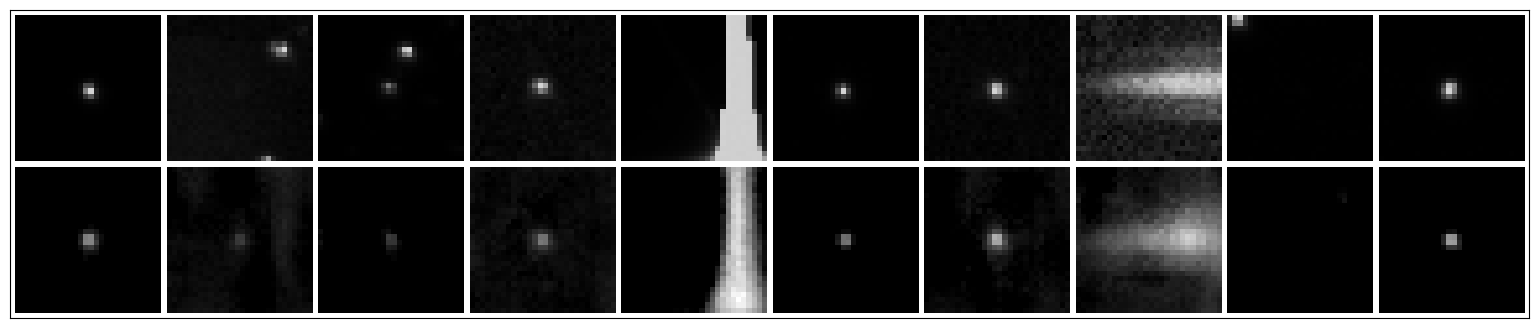

In [17]:
plot_imgs(run_res['real'][:10], run_res['reconstr'][:10], name='visualizations/vae_res.pdf')

In [22]:
mu, log_var = vae_split(run_res['latent'])
sigma = np.exp(0.5 * log_var)


(array([   22.,    89.,   167.,  2503.,  6250.,  8790., 14245., 17367.,
          872.,   454.]),
 array([-5.88450241, -4.96607733, -4.04765177, -3.12922645, -2.21080112,
        -1.29237592, -0.37395063,  0.54447466,  1.46289992,  2.38132524,
         3.29975057]),
 <BarContainer object of 10 artists>)

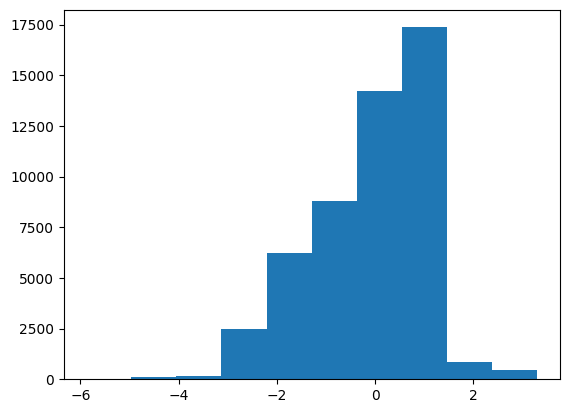

In [25]:
plt.hist(mu[:, 31])

## Visualization

In [26]:
latent_dim = 36

learning_rate = 5e-5
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)


In [20]:
encoder

VAEEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=72, bias=True)
  )
)

In [11]:
for batch in train_loader:
    y_enc = encoder(batch.to(device))
    break

mu, log_var = vae_split(y_enc)
sample = vae_reparametrize(mu, log_var) 
y_dec = decoder(sample)


In [28]:
input_name = ["Images"]
output_name = ["Latent state"]

torch.onnx.export(encoder.to('cpu'), batch, "encoder.onnx", input_names=input_name, output_names=output_name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ValueError: expected 4D input (got 3D input)

In [16]:
input_name = ["Latent state"]
output_name = ["Reconstructed image"]

torch.onnx.export(decoder.to('cpu'), sample.to('cpu'), "decoder.onnx", input_names=input_name, output_names=output_name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## MNIST

In [25]:
import torchvision.datasets as dset
import torchvision

train_set = dset.MNIST(
    root='mnist', train=True, transform=torchvision.transforms.ToTensor(), download=False
)

torch.manual_seed(42)

x_train, _ = random_split(train_set, [0.2, 0.8])

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    x_train, batch_size=batch_size, shuffle=True
)

In [9]:
def train(
    enc,
    dec,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):

    for batch_idx, (data, lab) in enumerate(loader): 
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(encoder, decoder, data, lab) # reconstructed image drom decoder 

        loss = loss_handler(data, output, latent) # compute loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                ).ljust(40), 
                "Loss: {:.6f}".format(loss.item())
            )

            
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(loader):
            if return_labels:
                labels.append(label.numpy())
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            label = label.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, label)
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [77]:
torch.manual_seed(42)

latent_dim = 24

learning_rate = 5e-4
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

device='cpu'
encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in tqdm(range(1, 6)):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=30,
    )

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/12000 (0%)]            Loss: 0.068260
Train Epoch: 1 [1920/12000 (16%)]        Loss: 0.046876
Train Epoch: 1 [3840/12000 (32%)]        Loss: 0.042329
Train Epoch: 1 [5760/12000 (48%)]        Loss: 0.043889
Train Epoch: 1 [7680/12000 (64%)]        Loss: 0.041058
Train Epoch: 1 [9600/12000 (80%)]        Loss: 0.040752
Train Epoch: 1 [11520/12000 (96%)]       Loss: 0.039840


 20%|█████████                                    | 1/5 [00:08<00:35,  8.78s/it]

Train Epoch: 2 [0/12000 (0%)]            Loss: 0.033203
Train Epoch: 2 [1920/12000 (16%)]        Loss: 0.034128
Train Epoch: 2 [3840/12000 (32%)]        Loss: 0.035548
Train Epoch: 2 [5760/12000 (48%)]        Loss: 0.036193
Train Epoch: 2 [7680/12000 (64%)]        Loss: 0.031099
Train Epoch: 2 [9600/12000 (80%)]        Loss: 0.034522
Train Epoch: 2 [11520/12000 (96%)]       Loss: 0.032732


 40%|██████████████████                           | 2/5 [00:17<00:25,  8.56s/it]

Train Epoch: 3 [0/12000 (0%)]            Loss: 0.032780
Train Epoch: 3 [1920/12000 (16%)]        Loss: 0.037630
Train Epoch: 3 [3840/12000 (32%)]        Loss: 0.032946
Train Epoch: 3 [5760/12000 (48%)]        Loss: 0.032816
Train Epoch: 3 [7680/12000 (64%)]        Loss: 0.032120
Train Epoch: 3 [9600/12000 (80%)]        Loss: 0.031961
Train Epoch: 3 [11520/12000 (96%)]       Loss: 0.033313


 60%|███████████████████████████                  | 3/5 [00:25<00:17,  8.54s/it]

Train Epoch: 4 [0/12000 (0%)]            Loss: 0.031925
Train Epoch: 4 [1920/12000 (16%)]        Loss: 0.030908
Train Epoch: 4 [3840/12000 (32%)]        Loss: 0.013943
Train Epoch: 4 [5760/12000 (48%)]        Loss: 0.009820
Train Epoch: 4 [7680/12000 (64%)]        Loss: 0.008775
Train Epoch: 4 [9600/12000 (80%)]        Loss: 0.008806
Train Epoch: 4 [11520/12000 (96%)]       Loss: 0.008896


 80%|████████████████████████████████████         | 4/5 [00:34<00:08,  8.52s/it]

Train Epoch: 5 [0/12000 (0%)]            Loss: 0.008793
Train Epoch: 5 [1920/12000 (16%)]        Loss: 0.008126
Train Epoch: 5 [3840/12000 (32%)]        Loss: 0.008306
Train Epoch: 5 [5760/12000 (48%)]        Loss: 0.008007
Train Epoch: 5 [7680/12000 (64%)]        Loss: 0.008238
Train Epoch: 5 [9600/12000 (80%)]        Loss: 0.008510
Train Epoch: 5 [11520/12000 (96%)]       Loss: 0.008287


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


In [78]:
encoder = encoder.eval()
decoder = decoder.eval()

In [79]:
run_res = run_eval(encoder, decoder, train_loader, vae_pass_handler)

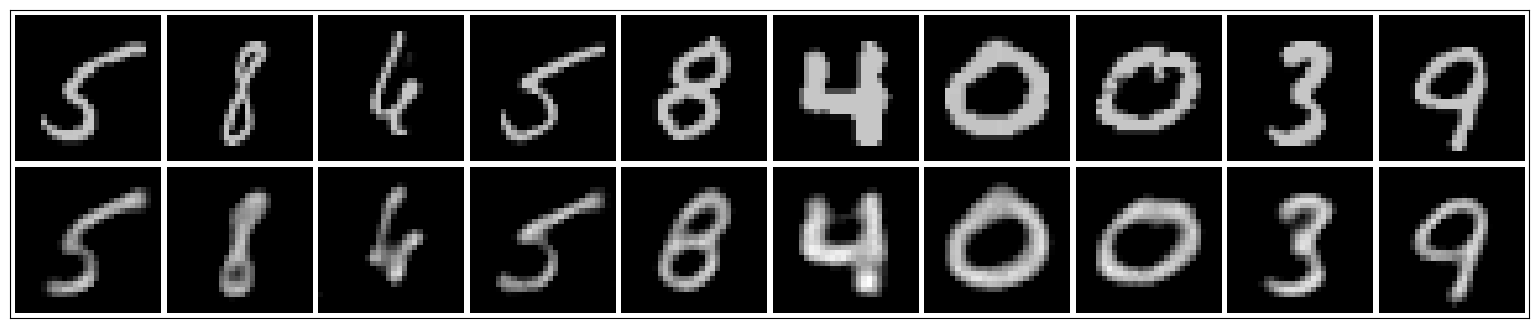

In [80]:
plot_imgs(run_res['real'][100:110], run_res['reconstr'][100:110])

In [81]:
mu, log_var = vae_split(run_res['latent'])
sigma = np.exp(0.5 * log_var)


(array([  57.,  309., 1309., 2469., 3003., 2270., 1457.,  864.,  244.,
          18.]),
 array([-2.94192767, -2.2691412 , -1.59635484, -0.92356849, -0.25078207,
         0.42200434,  1.0947907 ,  1.76757717,  2.44036365,  3.11314988,
         3.78593636]),
 <BarContainer object of 10 artists>)

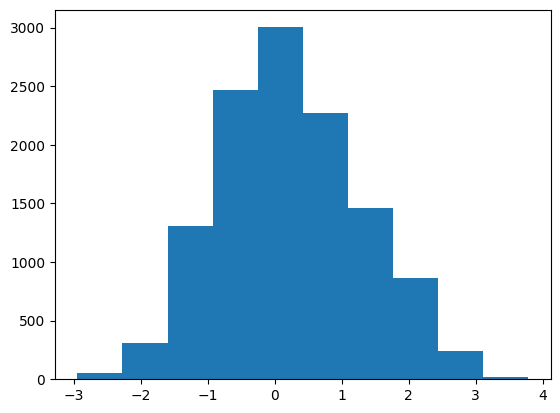

In [85]:
plt.hist(mu[:,1])